In [1]:
import sys
import torch
import os 
import numpy as np
from PIL import Image, ImageOps
import torchvision.transforms as transforms
# import wandb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from PIL import Image
sys.path.append('..')  
import scipy

from types import SimpleNamespace
from model.model import MMC  
from src.config import Config

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

/home/raghav/multimodal-classification/UniS-MMC/.venv_mm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

cuda


In [3]:
args = SimpleNamespace(
    name='MMC',
    dataset='n24news',  # Adjust as per your dataset or requirement
    text_type='abstract',
    mmc='UniSMMC',
    mmc_tao=0.07,
    batch_size=100,
    lr_mm=0.001,
    min_epoch=1,
    valid_step=50,
    max_length=512,
    text_encoder='roberta_base',
    image_encoder='vit_base',
    text_out=768,
    img_out=768,
    lr_mm_cls=0.001,
    mm_dropout=0.0,
    lr_text_tfm=2e-5,
    lr_img_tfm=5e-5,
    lr_img_cls=0.0001,
    lr_text_cls=5e-5,
    text_dropout=0.0,
    img_dropout=0.1,
    nplot='',
    data_dir='../datasets/',  # Ensure this path is correct in your notebook environment
    test_only=False,
    pretrained_dir='../pretrained_models',  # Adjust as necessary
    model_save_dir='Path/To/results/models',
    res_save_dir='Path/To/results/results',
    fig_save_dir='Path/To/results/imgs',
    logs_dir='Path/To/results/logs',
    local_rank=-1,
    seeds=None,
    model_path='./Path/To/results/models',
    save_model=True,
    cross_attention=False,
    text_mixup=False,
    image_mixup=False,
    image_embedding_mixup=False,
    alpha=0.2,
    multi_mixup=True,
    mixup_pct=0.33,
    lambda_mixup=0.1,
    mixup_beta=0.15,
    mixup_s_thresh=0.5,
    lr_scheduler='ReduceLROnPlateau',
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

config = Config(args)
args = config.get_config()

np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

if args.local_rank == -1:
    device = torch.device("cuda")
else:
    torch.cuda.set_device(args.local_rank)
    device = torch.device("cuda", args.local_rank)
    torch.distributed.init_process_group(backend="nccl")

args.device = device
print(args.data_dir)
args.data_dir = os.path.join(args.data_dir, args.dataset)

#args.best_model_save_path = os.path.join(args.model_save_dir, f'{args.dataset}-best-{time.strftime("%Y%m%d-%H%M%S")}.pth')v

../datasets/


In [4]:
print(args.device)

cuda


In [5]:
from model.utils import *
#from model.model import MMC
from model.model_noise_random import MMC
from model.model_cross import MMC_Cross
from data.dataloader import MMDataLoader

In [6]:
train_loader, valid_loader, test_loader = MMDataLoader(args)

../datasets/n24news/news/nytimes_train.json
../datasets/n24news/news/nytimes_dev.json
../datasets/n24news/news/nytimes_test.json


In [7]:
model = MMC(args).to(args.device)

In [10]:
# model_path = '/home/raghav/multimodal-classification/UniS-MMC/saved-models-for-visualization/Food101-best-m3co.pth'
# model_path = '/home/raghav/multimodal-classification/UniS-MMC/saved-models-for-visualization/Food101-best-mixup.pth'
# model_path= '/home/raghav/multimodal-classification/UniS-MMC/saved-models-for-visualization/Food101-best-m3co+multisoftclip.pth'

model_path = '/home/raghav/multimodal-classification/UniS-MMC/saved-models-for-visualization/n24news-best-m3co+multisoftclip-abstract.pth'
model_path = '/home/raghav/multimodal-classification/UniS-MMC/saved-models-for-visualization/n24news-best-no-unimodal-abstract.pth'
#model_path = '/home/raghav/multimodal-classification/UniS-MMC/saved-models-for-visualization/n24news-best-mixup-abstract.pth'
model.load_state_dict(torch.load(model_path), strict=False)
model = model.to(device=args.device)

In [11]:
dataloader = test_loader

In [12]:
model.eval()
with torch.no_grad():
        y_pred = []
        y_true = []
        with tqdm(dataloader) as td:
            for batch_image, text_input_ids, text_token_type_ids, text_attention_mask, batch_label in td:
                text = text_input_ids.cuda(), text_token_type_ids.cuda(), text_attention_mask.cuda()
                image = batch_image.cuda()
                logit = model.infer(text, image, None)
                y_pred.append(logit.cpu())
                y_true.append(batch_label.cpu())
                break
            
        logits = torch.cat(y_pred)
        true = torch.cat(y_true).data.cpu().numpy()
        prob = F.softmax(logits, dim=1).data.cpu().numpy()

  0%|          | 0/191 [00:02<?, ?it/s]


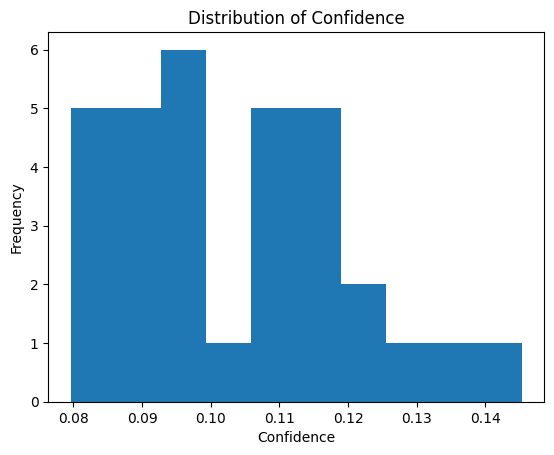

In [13]:
softmax_logits = F.softmax(logits, dim=1)
max_values, _ = torch.max(softmax_logits, dim=1)

plt.hist(max_values, bins=10)
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence')
plt.show()